For each class, there is one pattern occurring in the data. Solving just a classification task be scored no higher than 70%.

Please provide either pdf with the report or add some notes in the notebook. Demonstrate some examples of how your approach works.

A short reminder of your task:
 - Correct classification of provided time series
 - Explanation of the prediction (showing which part of which series is responsible for a defect)
 - Neural network with at least one recurrent layer must be used in each step
 - Not the whole logic must be inside the neural network
 - Your approach should work for other data, of course after retraining. It means you shouldn't take advantage of knowing the series are based on sin function and how the anomalies are created.

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense, Lambda
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split

In [31]:
np.random.seed(42)

In [32]:
n = 50000

In [33]:
def createRow(n, classes):
    base = np.sin(np.linspace((np.random.rand(3)),(np.random.rand(3) + np.array([10,15,7])),n))
    if classes[0] > 0:
        base[np.random.randint(0,n), 0] += 2
    if classes[1] > 0:
        base[np.random.randint(0,n), 1] -= 2
    if classes[2] > 0:
        x = np.random.randint(0,n-5)
        base[x:x+4,2] = 0
    if classes[3] > 0:
        x = np.random.randint(0,n-10)
        base[x:x+8,1] += 1.5
    if classes[4] > 0:
        x = np.random.randint(0,n-7)
        base[x:x+6,0] += 1.5
        base[x:x+6,2] -= 1.5
    base += np.random.rand(*base.shape)*.2
    return base

In [34]:
xl, yl = [], []
for _ in range(n):
    cl = np.random.rand(5)<.25
    xl.append(createRow(np.random.randint(40,60), cl))
    yl.append(cl)


[False False False False  True]


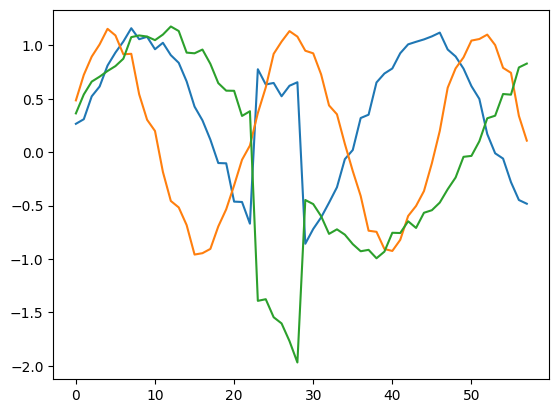

[False False False  True  True]


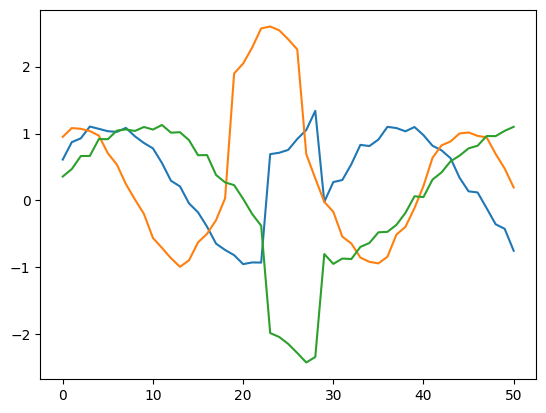

[False False False False False]


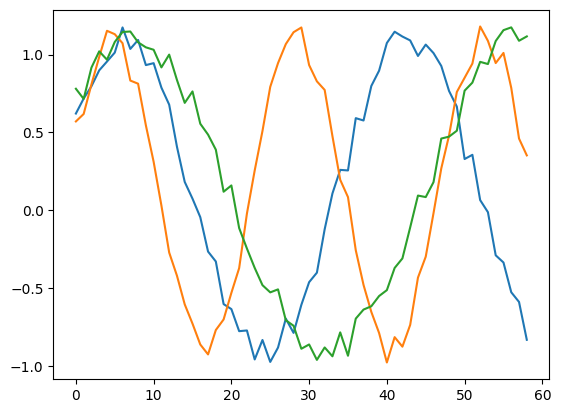

[ True False False False  True]


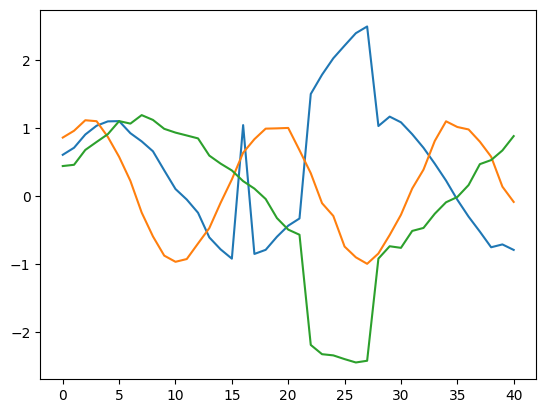

[False  True False False False]


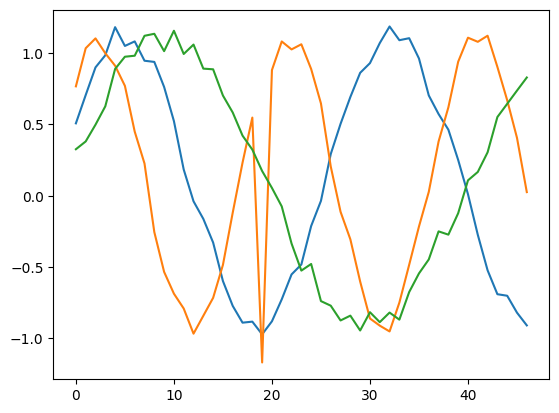

In [50]:
for i in range(5):
    plt.plot(xl[i])
    print(yl[i])
    plt.show()

# DUAP
--------------------------------

In [37]:

# # Preprocessing
# max_length = max(map(len, xl))
# xl_padded = [np.pad(x, ((0, max_length - len(x)), (0, 0)), 'constant') for x in xl]
# X = np.array(xl_padded)
# y = np.array(yl)

# # Split dataset
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Model definition
# input_layer = Input(shape=(max_length, 3))
# lstm_out = LSTM(64, return_sequences=True)(input_layer)
# conv_out = Conv1D(32, kernel_size=3, activation='relu', padding='same')(lstm_out)
# global_pool = GlobalMaxPooling1D()(conv_out)
# output_layer = Dense(5, activation='sigmoid')(global_pool)

# model = Model(inputs=input_layer, outputs=output_layer)
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# # Train the model
# history = model.fit(X_train, y_train, validation_split=0.2, epochs=20, batch_size=32)

# # Evaluate the model
# loss, accuracy = model.evaluate(X_test, y_test)
# print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")



In [38]:
# # Explanation of predictions
# sample_idx = 2
# sample = X_test[sample_idx:sample_idx + 1]
# predictions = model.predict(sample)[0]
# print(predictions)

# # Plot the sample and highlight anomalies
# def plot_sample_with_anomalies(sample, predictions):
#     plt.figure(figsize=(12, 6))
#     for i in range(sample.shape[1]):
#         plt.plot(sample[:, i], label=f"Channel {i+1}")
#         if predictions[i] > 0.5:
#             plt.fill_between(range(sample.shape[0]), sample[:, i], alpha=0.3, label=f"Anomaly in Channel {i+1}")
#     plt.legend()
#     plt.title("Sample with Detected Anomalies")
#     plt.show()

# plot_sample_with_anomalies(sample[0], predictions)


# different approach

In [39]:
xl = np.array(xl, dtype=object)
yl = np.array(yl)

# Create windows
def create_windows(x, y, window_size):
    X_windows, Y_windows = [], []
    for series, label in zip(x, y):
        n = series.shape[0]
        
        # Process the series in non-overlapping chunks
        for i in range(0, n, window_size):
            window = series[i:i + window_size]
            
            # Only keep windows of the specified size
            if window.shape[0] == window_size:
                X_windows.append(window)
                
                # Assign labels based on anomalies in the window
                # If any anomaly from y occurs in this window, the window is marked accordingly
                window_label = (label > 0).astype(int)  # Keep the full label set
                Y_windows.append(window_label)
    
    return np.array(X_windows), np.array(Y_windows)


window_size = 10

X_windows, Y_windows = create_windows(xl, yl, window_size)

In [40]:
print(len(Y_windows))

50000


In [41]:


# Create "any anomaly" target
Y_any_anomaly = (Y_windows.sum(axis=1) > 0).astype(int)

# Split the dataset
X_train, X_test, Y_train_specific, Y_test_specific = train_test_split(X_windows, Y_windows, test_size=0.2, random_state=42)
Y_train_any = (Y_train_specific.sum(axis=1) > 0).astype(int)
Y_test_any = (Y_test_specific.sum(axis=1) > 0).astype(int)

# Define the model
input_layer = Input(shape=(window_size, 3))
x = LSTM(64, return_sequences=True)(input_layer)
x = Dropout(0.3)(x)
x = LSTM(32, return_sequences=False)(x)
x = Dropout(0.3)(x)

# Outputs
specific_anomalies = Dense(5, activation='sigmoid', name='specific_anomalies')(x)
any_anomaly = Lambda(lambda x: K.max(x, axis=1, keepdims=True), name='any_anomaly')(specific_anomalies)

# Multi-output model
model = Model(inputs=input_layer, outputs=[specific_anomalies, any_anomaly])
model.compile(
    optimizer='adam',
    loss={'specific_anomalies': 'binary_crossentropy', 'any_anomaly': 'binary_crossentropy'},
    loss_weights={'specific_anomalies': 0.5, 'any_anomaly': 0.5},
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    X_train, 
    {'specific_anomalies': Y_train_specific, 'any_anomaly': Y_train_any},
    validation_split=0.2,
    epochs=20,
    batch_size=32
)

# Evaluate the model
evaluation = model.evaluate(X_test, {'specific_anomalies': Y_test_specific, 'any_anomaly': Y_test_any})
print("Test Loss and Accuracy:", evaluation)



Epoch 1/20
4500/4500 [==============================] - 61s 13ms/step - loss: 0.5676 - specific_anomalies_loss: 0.6064 - any_anomaly_loss: 0.5288 - specific_anomalies_accuracy: 0.2393 - any_anomaly_accuracy: 0.7644 - val_loss: 0.5441 - val_specific_anomalies_loss: 0.5769 - val_any_anomaly_loss: 0.5114 - val_specific_anomalies_accuracy: 0.3065 - val_any_anomaly_accuracy: 0.7652
Epoch 2/20
4500/4500 [==============================] - 60s 13ms/step - loss: 0.5330 - specific_anomalies_loss: 0.5706 - any_anomaly_loss: 0.4954 - specific_anomalies_accuracy: 0.3981 - any_anomaly_accuracy: 0.7655 - val_loss: 0.5103 - val_specific_anomalies_loss: 0.5407 - val_any_anomaly_loss: 0.4799 - val_specific_anomalies_accuracy: 0.4467 - val_any_anomaly_accuracy: 0.7656
Epoch 3/20
4500/4500 [==============================] - 53s 12ms/step - loss: 0.5101 - specific_anomalies_loss: 0.5426 - any_anomaly_loss: 0.4776 - specific_anomalies_accuracy: 0.4559 - any_anomaly_accuracy: 0.7659 - val_loss: 0.4984 - val_

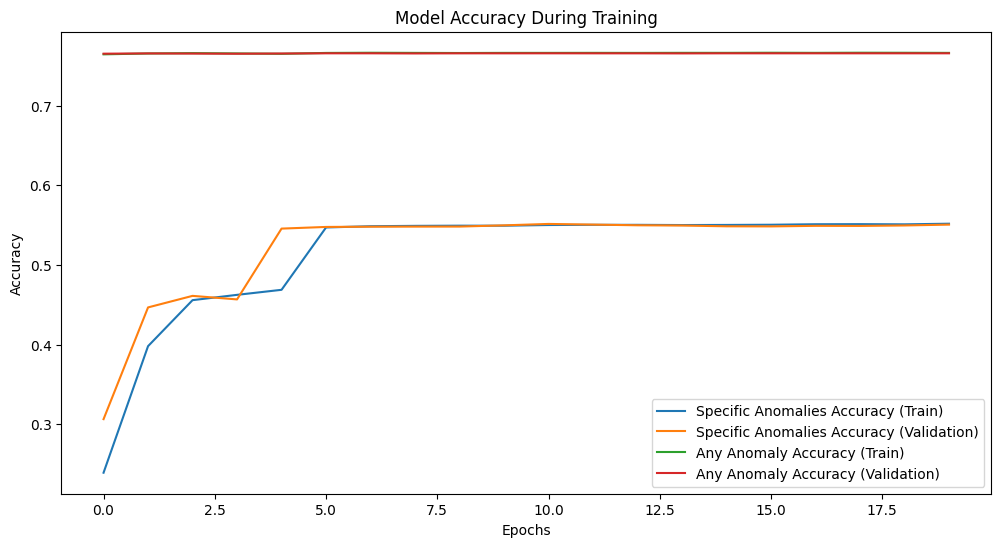

1/1 [==============================] - 0s 79ms/step
Sample 1:


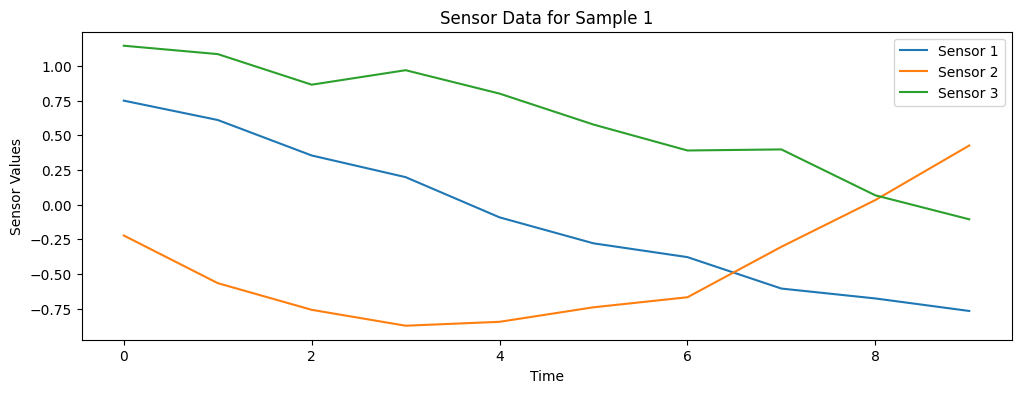

Anomaly detected: YES
Specific Anomaly Probabilities: [0.57271236 0.20894755 0.22225809 0.15945625 0.1708788 ]
Likely Anomalies: [0]

-----------------------------

Sample 2:


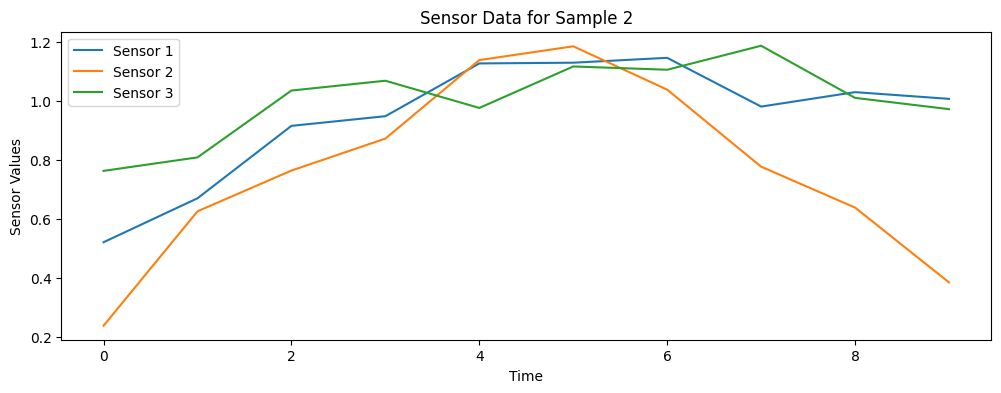

Anomaly detected: YES
Specific Anomaly Probabilities: [0.6012217  0.20979308 0.2049854  0.19709472 0.19649176]
Likely Anomalies: [0]

-----------------------------

Sample 3:


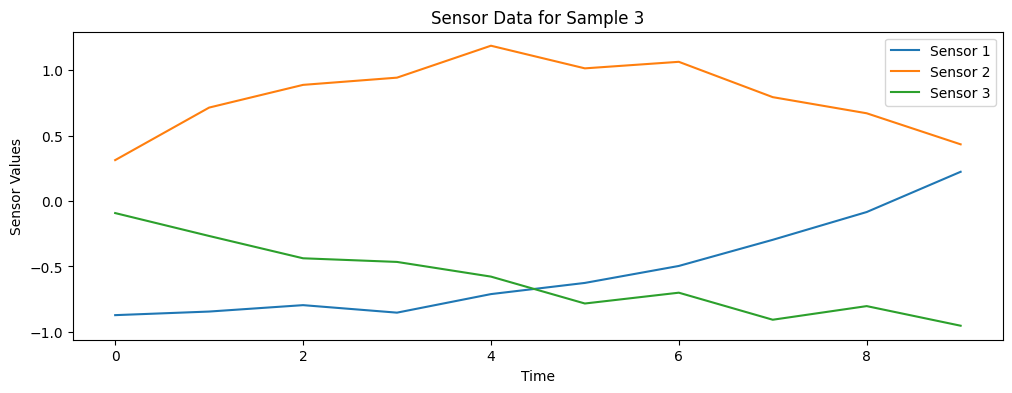

Anomaly detected: YES
Specific Anomaly Probabilities: [0.58626145 0.20970553 0.19837399 0.16581635 0.1775681 ]
Likely Anomalies: [0]

-----------------------------

Sample 4:


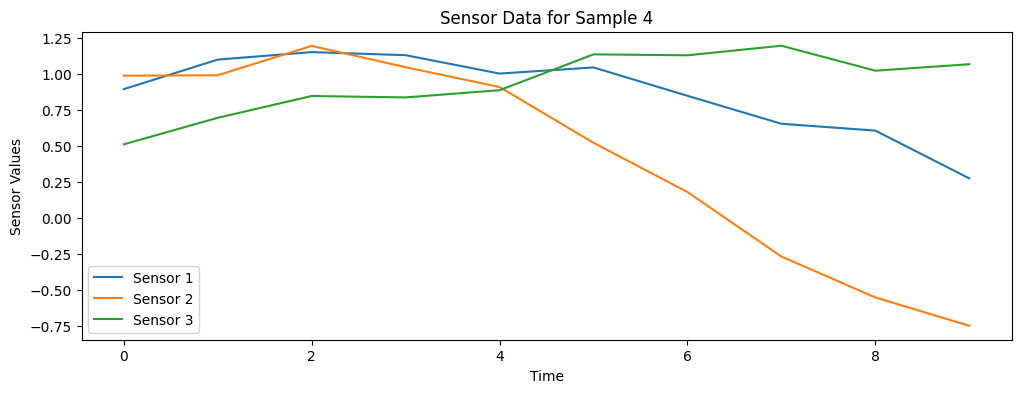

Anomaly detected: YES
Specific Anomaly Probabilities: [0.5955016  0.209535   0.2058327  0.19734965 0.19622473]
Likely Anomalies: [0]

-----------------------------

Sample 5:


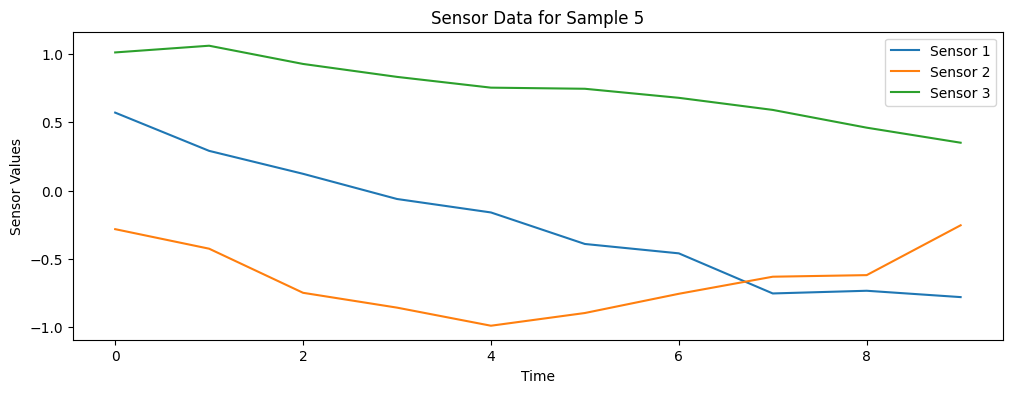

Anomaly detected: YES
Specific Anomaly Probabilities: [0.59281653 0.20956692 0.19931921 0.18137746 0.18951349]
Likely Anomalies: [0]

-----------------------------



In [43]:
# Visualization of training process
plt.figure(figsize=(12, 6))
plt.plot(history.history['specific_anomalies_accuracy'], label='Specific Anomalies Accuracy (Train)')
plt.plot(history.history['val_specific_anomalies_accuracy'], label='Specific Anomalies Accuracy (Validation)')
plt.plot(history.history['any_anomaly_accuracy'], label='Any Anomaly Accuracy (Train)')
plt.plot(history.history['val_any_anomaly_accuracy'], label='Any Anomaly Accuracy (Validation)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy During Training')
plt.show()

# Prediction and visualization
def visualize_predictions(X_sample, Y_sample_specific, Y_sample_any):
    predictions = model.predict(X_sample)
    specific_preds, any_preds = predictions

    for i in range(len(X_sample)):
        print(f"Sample {i + 1}:")
        plt.figure(figsize=(12, 4))

        for sensor_idx in range(3):
            plt.plot(X_sample[i][:, sensor_idx], label=f'Sensor {sensor_idx + 1}')
        
        plt.title(f"Sensor Data for Sample {i + 1}")
        plt.xlabel("Time")
        plt.ylabel("Sensor Values")
        plt.legend()
        plt.show()

        if any_preds[i] > 0.5:
            print("Anomaly detected: YES")
            print("Specific Anomaly Probabilities:", specific_preds[i])
            print("Likely Anomalies:", np.where(specific_preds[i] > 0.5)[0])
        else:
            print("Anomaly detected: NO")

        print("\n-----------------------------\n")

# Test visualization with a sample of test data
X_sample = X_test[:5]
Y_sample_specific = Y_test_specific[:5]
Y_sample_any = Y_test_any[:5]
visualize_predictions(X_sample, Y_sample_specific, Y_sample_any)

## multiclass label classification. 
- each instance can belong to multiple classes at once.
- binary corssentropy applied to each output (class)
- sigmoid function for wach class
- output with multiple dimentions

Loss:
- hamming losss (compare set of predicted labels to set of actual labels)
- loss: 
CategoricalCrossentropy

Metrics: 
- Hamming Loss: Measures the average proportion of labels that were incorrectly predicted.
- F1 Score: Provides a balance between Precision and Recall.
- Jaccard Index: Measures the similarity between predicted and actual labels.
- Subset Accuracy: Measures the percentage of labels that are exactly correct.
Precision, Recall, F1 Score, Hamming Loss, Subset Accuracy, and AUC-ROC

Consider: 
- normalization
- randomsearch hyperparameter tuning
- ensemble methods? stacking rnns? [if too much time lol]

### Padding and masking! for diffferent lenghts of variables

- garnki: https://www.youtube.com/watch?v=jyphzUamJrQ

### use this code:


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(3, sequence_length)),
    LSTM(32, return_sequences=False),
    Dense(16, activation='relu'),
    Dense(n_classes, activation='sigmoid')  # Multi-label classification
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)


--------------------------
### masking


In [89]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, AUC
from sklearn.preprocessing import MinMaxScaler


In [90]:
# Convert to multi-hot encoded labels


num_classes = len(yl[0])

def true_false_to_multi_hot(labels, num_classes):
    encoded_labels = []
    for label in labels:
        multi_hot_label = [1 if x else 0 for x in label]
        encoded_labels.append(multi_hot_label)
    return np.array(encoded_labels)


multi_hot_labels = true_false_to_multi_hot(yl, num_classes)


In [91]:
# Padding because of varying sequence lengths

sequence_lengths = [len(seq) for seq in xl]
max_len = max(sequence_lengths)
padded_sequences = pad_sequences(xl, maxlen=max_len, padding='post', dtype='float32')  #post means that the padding is added after the sequence

#Min-Max scaling
scaler = MinMaxScaler(feature_range=(0, 1))
padded_sequences = scaler.fit_transform(padded_sequences.reshape(-1, 3)).reshape(-1, padded_sequences.shape[1], 3)


#split data 80-20
X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences, multi_hot_labels, test_size=0.2, random_state=42
)

# Define the model with a Masking layer to not train on the padded parts. 
model = Sequential([
    Masking(mask_value=0, input_shape=(max_len, 3)),
    LSTM(64),
    # LSTM(32),
    Dense(5, activation='sigmoid')  # Multi-label classification for 5 potential anomalies
])

model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_16 (Masking)        (None, 59, 3)             0         
                                                                 
 lstm_30 (LSTM)              (None, 64)                17408     
                                                                 
 dense_16 (Dense)            (None, 5)                 325       
                                                                 
Total params: 17733 (69.27 KB)
Trainable params: 17733 (69.27 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [93]:
# Compile the model
model.compile(optimizer=Adam(), 
              loss='binary_crossentropy',  # Use categorical crossentropy for multi-label classification
              metrics=['accuracy'])  # Hamming Loss, Subset Accuracy dont work

# , Precision(), Recall(), AUC()

# Fiting the model
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_test, y_test)  # Use test set for validation during training
)


Epoch 1/30
1250/1250 [==============================] - 35s 26ms/step - loss: 0.4598 - accuracy: 0.2551 - val_loss: 0.4482 - val_accuracy: 0.2017
Epoch 2/30
1250/1250 [==============================] - 39s 31ms/step - loss: 0.4470 - accuracy: 0.2978 - val_loss: 0.4190 - val_accuracy: 0.2767
Epoch 3/30
1250/1250 [==============================] - 40s 32ms/step - loss: 0.3988 - accuracy: 0.3359 - val_loss: 0.3949 - val_accuracy: 0.5159
Epoch 4/30
1250/1250 [==============================] - 38s 31ms/step - loss: 0.3852 - accuracy: 0.3728 - val_loss: 0.3649 - val_accuracy: 0.3518
Epoch 5/30
1250/1250 [==============================] - 37s 30ms/step - loss: 0.3298 - accuracy: 0.4160 - val_loss: 0.2993 - val_accuracy: 0.4265
Epoch 6/30
1250/1250 [==============================] - 36s 29ms/step - loss: 0.2999 - accuracy: 0.4188 - val_loss: 0.3357 - val_accuracy: 0.3313
Epoch 7/30
1250/1250 [==============================] - 31s 25ms/step - loss: 0.2708 - accuracy: 0.4258 - val_loss: 0.2435 -

In [94]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=2)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


5000/5000 [==============================] - 37s 7ms/step - loss: 0.1047 - accuracy: 0.5367
Test Loss: 0.10467662662267685
Test Accuracy: 0.5367000102996826


In [98]:
# %pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [99]:
# Predict on the test set
test_predictions = model.predict(X_test)

# Apply thresholding for binary results
threshold = 0.5
binary_test_predictions = (test_predictions > threshold).astype(int)


313/313 [==============================] - 3s 10ms/step


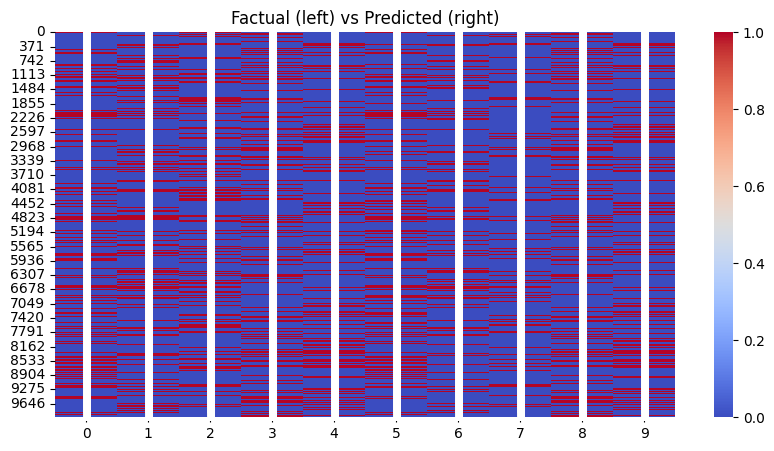

In [102]:
# Comparison list

# comparison_df = pd.DataFrame({
#     'Factual': [list(row) for row in y_test],
#     'Predicted': [list(row) for row in binary_test_predictions]
# })

# print(comparison_df)



import seaborn as sns
import matplotlib.pyplot as plt

# Stack factual and predicted side by side
combined = np.hstack([y_test, binary_test_predictions])

# Heatmap visualization
plt.figure(figsize=(10, 5))
sns.heatmap(combined, annot=True, fmt="d", cmap="coolwarm")
plt.title("Factual (left) vs Predicted (right)")
plt.show()
